c:\ProgramData\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


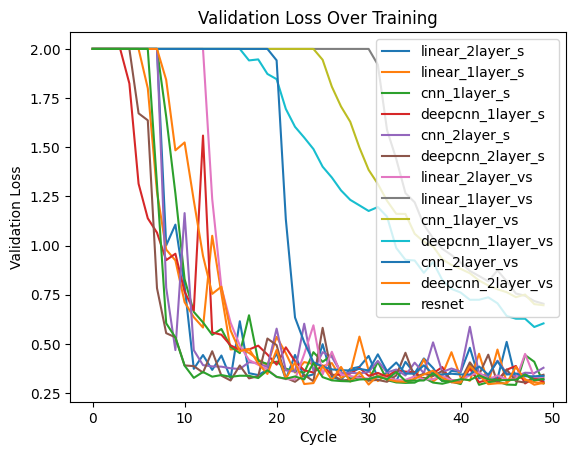

In [2]:
import torch
import matplotlib.pyplot as plt
from models import *
from helpersGeneration import *
%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# Load training results
results = torch.load("training_results.pth")

# Extract data
validation_losses = results["validation_losses"]
all_labels = results["all_labels"]
model_weights = results["model_weights"]

# Example: Plot validation loss curves
for model_name, losses in validation_losses.items():
    plt.plot(np.clip(losses["val_avg"],0,2), label=model_name)

plt.xlabel("Cycle")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Validation Loss Over Training")
plt.show()


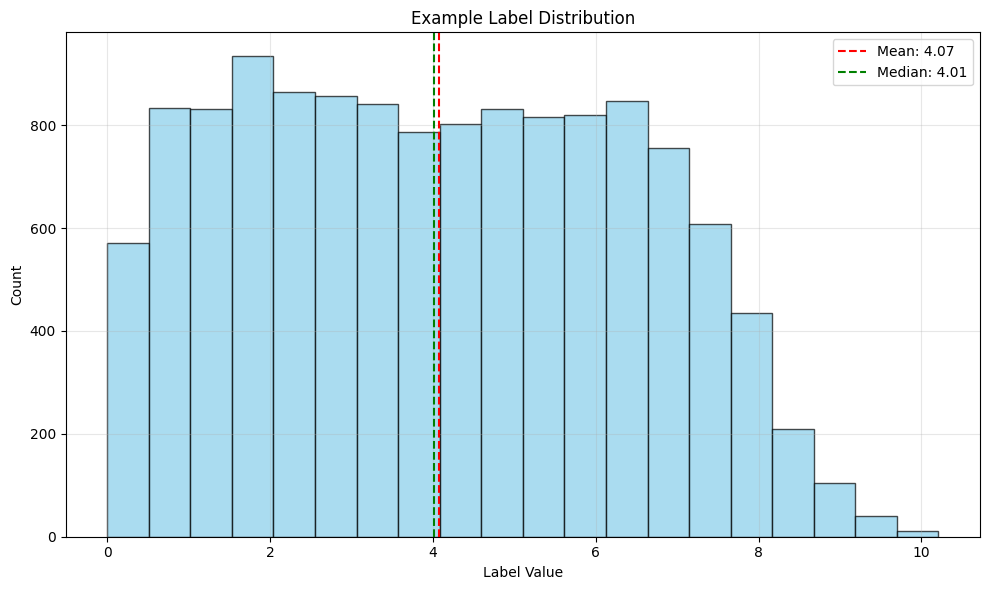

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_labels_histogram(labels_array, bins=10, title="Distribution of Labels", 
                          xlabel="Value", ylabel="Frequency", 
                          color='skyblue', edgecolor='black',
                          figsize=(10, 6), show_grid=True, 
                          show_mean=True, show_median=True):
    """
    Plot a histogram from a numpy array of labels.
    
    Parameters:
    -----------
    labels_array : numpy.ndarray
        The array of values to plot as histogram
    bins : int or sequence, default=10
        Number of bins or bin edges
    title : str, default="Distribution of Labels"
        Title of the plot
    xlabel : str, default="Value"
        Label for x-axis
    ylabel : str, default="Frequency"
        Label for y-axis
    color : str, default='skyblue'
        Color of the histogram bars
    edgecolor : str, default='black'
        Color of the histogram bar edges
    figsize : tuple, default=(10, 6)
        Figure size (width, height) in inches
    show_grid : bool, default=True
        Whether to show grid lines
    show_mean : bool, default=True
        Whether to show the mean line
    show_median : bool, default=True
        Whether to show the median line
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
        For further customization if needed
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram
    ax.hist(labels_array, bins=bins, color=color, edgecolor=edgecolor, alpha=0.7)
    
    # Add mean line if requested
    if show_mean and len(labels_array) > 0:
        mean_value = np.mean(labels_array)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                  label=f'Mean: {mean_value:.2f}')
    
    # Add median line if requested
    if show_median and len(labels_array) > 0:
        median_value = np.median(labels_array)
        ax.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Median: {median_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add grid
    if show_grid:
        ax.grid(alpha=0.3)
    
    # Add legend if we have mean or median
    if (show_mean or show_median) and len(labels_array) > 0:
        ax.legend()
    
    plt.tight_layout()
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Example data
    
    # Plot histogram
    fig, ax = plot_labels_histogram(
        all_labels, 
        bins=20,
        title="Example Label Distribution",
        xlabel="Label Value",
        ylabel="Count"
    )
    
    plt.show()

In [4]:
import torch

# Define model hyperparameters
patch_size = 7
embed_dim = 64
num_heads = 4
hidden_dim = 128
num_layers = 6
dropout = 0.0


# Recreate all models
models = get_transformer_models(patch_size, embed_dim, num_heads, hidden_dim, num_layers, dropout, name_suffix="_s")
#models_big = get_transformer_models(patch_size, embed_dim * 2, num_heads * 2, hidden_dim * 2, num_layers * 2, dropout, name_suffix="_b")
#models.update(models_big)


models_very_small = get_transformer_models(patch_size, embed_dim//2, num_heads//2, hidden_dim//2, num_layers//2, dropout,name_suffix='_vs')

models.update(models_very_small)


resnet = MultiImageLightResNet(patch_size)
models.update({"resnet": resnet})

# Load saved training results
save_path = "training_results.pth"
checkpoint = torch.load(save_path)

# Load model weights
for name, model in models.items():
    if name in checkpoint["model_weights"]:
        model.load_state_dict(checkpoint["model_weights"][name])
        model.eval()  # Set to evaluation mode
        print(f"Loaded weights for {name}")
    else:
        print(f"Warning: No saved weights found for {name}")

# Retrieve stored validation losses and labels
validation_losses = checkpoint["validation_losses"]
all_labels = checkpoint["all_labels"]

print("Loaded validation losses and labels for analysis.")




Loaded weights for linear_2layer_s
Loaded weights for linear_1layer_s
Loaded weights for cnn_1layer_s
Loaded weights for deepcnn_1layer_s
Loaded weights for cnn_2layer_s
Loaded weights for deepcnn_2layer_s
Loaded weights for linear_2layer_vs
Loaded weights for linear_1layer_vs
Loaded weights for cnn_1layer_vs
Loaded weights for deepcnn_1layer_vs
Loaded weights for cnn_2layer_vs
Loaded weights for deepcnn_2layer_vs
Loaded weights for resnet
Loaded validation losses and labels for analysis.


In [5]:
nPosPerFrame = 10 
background_mean, background_sigma = 100,10
part_mean, part_sigma = 500,20
image_props={"upsampling_factor":10,
      "background_intensity": [background_mean,background_sigma],
      "particle_intensity": [part_mean,part_sigma],
      "resolution": 100e-9,
      "trajectory_unit" : 1000,
      "output_size": 7,
      "poisson_noise" : -1
        }

traj_div_factor = 100


def load_validation_data():

    trajs1 = np.load("./valTrajs/val1.npy") /traj_div_factor
    trajs3 = np.load("./valTrajs/val3.npy") /traj_div_factor
    trajs5 = np.load("./valTrajs/val5.npy") /traj_div_factor
    trajs7 = np.load("./valTrajs/val7.npy") /traj_div_factor


    vid1 = trajectories_to_video(trajs1,nPosPerFrame,center=True,image_props=image_props)
    vid1,_ = normalize_images(vid1,background_mean,background_sigma,part_mean+background_mean)

    vid3 = trajectories_to_video(trajs3,nPosPerFrame,center=True,image_props=image_props)
    vid3,_ = normalize_images(vid3,background_mean,background_sigma,part_mean+background_mean)

    vid5 = trajectories_to_video(trajs5,nPosPerFrame,center=True,image_props=image_props)
    vid5,_ = normalize_images(vid5,background_mean,background_sigma,part_mean+background_mean)

    vid7 = trajectories_to_video(trajs7,nPosPerFrame,center=True,image_props=image_props)
    vid7,_ = normalize_images(vid7,background_mean,background_sigma,part_mean+background_mean)

    return torch.Tensor(vid1),torch.Tensor(vid3), torch.Tensor(vid5), torch.Tensor(vid7)

# Load validation dataset (fixed, does not change across cycles)
val_videos = load_validation_data()  # Returns (vid1, vid3, vid5, vid7)
val_labels = torch.tensor([1, 3, 5, 7], dtype=torch.float32)  # Corresponding labels

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_predictions_violin(models, val_videos, val_labels, chosen_label):
    """
    Plots a violin plot of the predictions of all models for a specific validation dataset.

    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """

    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return

    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx]  # Get corresponding video

    predictions = {}

    # Compute predictions for each model
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            preds = model(chosen_video).squeeze().tolist()  # Get all predictions for this video
            predictions[name] = preds  # Store as list

    # Prepare data for Seaborn
    data = []
    for model_name, preds in predictions.items():
        for pred in preds:
            data.append({"Model": model_name, "Prediction": pred})

    # Convert to DataFrame for easy plotting
    import pandas as pd
    df = pd.DataFrame(data)

    # Plot violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x="Model", y="Prediction", data=df, inner="box", palette="coolwarm")

    # Add reference line for true label
    plt.axhline(y=chosen_label, color='r', linestyle='--', label=f"True Value: {chosen_label}")

    plt.xlabel("Model")
    plt.ylabel("Predicted Value")
    plt.title(f"Distribution of Model Predictions for Validation Set {chosen_label}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()



C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_29024\4147665457.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Model", y="Prediction", data=df, inner="box", palette="coolwarm")


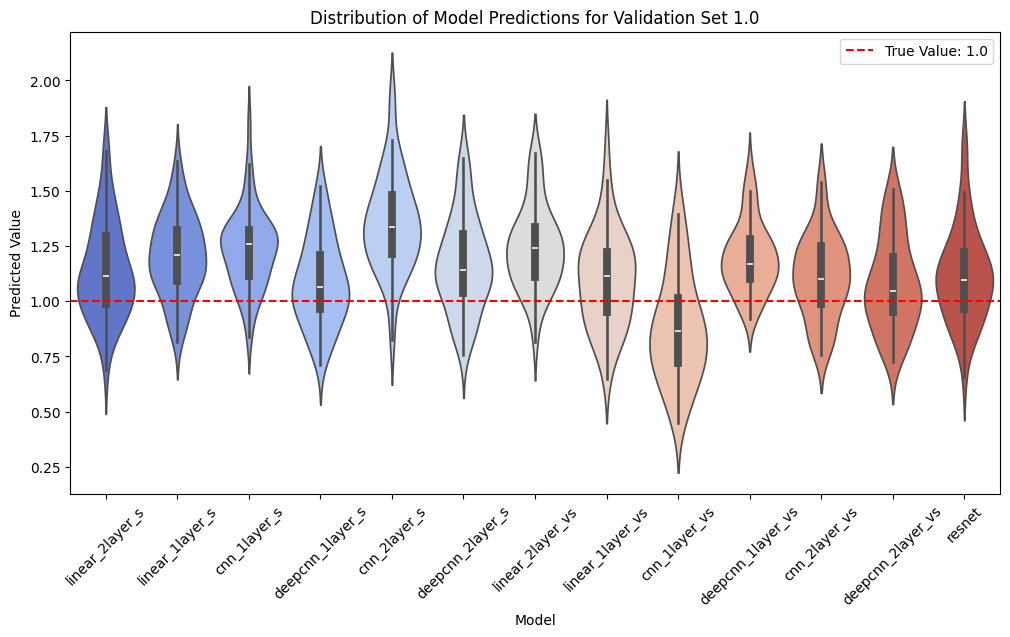

In [7]:
plot_model_predictions_violin(models, val_videos, val_labels, chosen_label=1.0)

C:\Users\Silly Emilien\AppData\Local\Temp\ipykernel_29024\4147665457.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Model", y="Prediction", data=df, inner="box", palette="coolwarm")


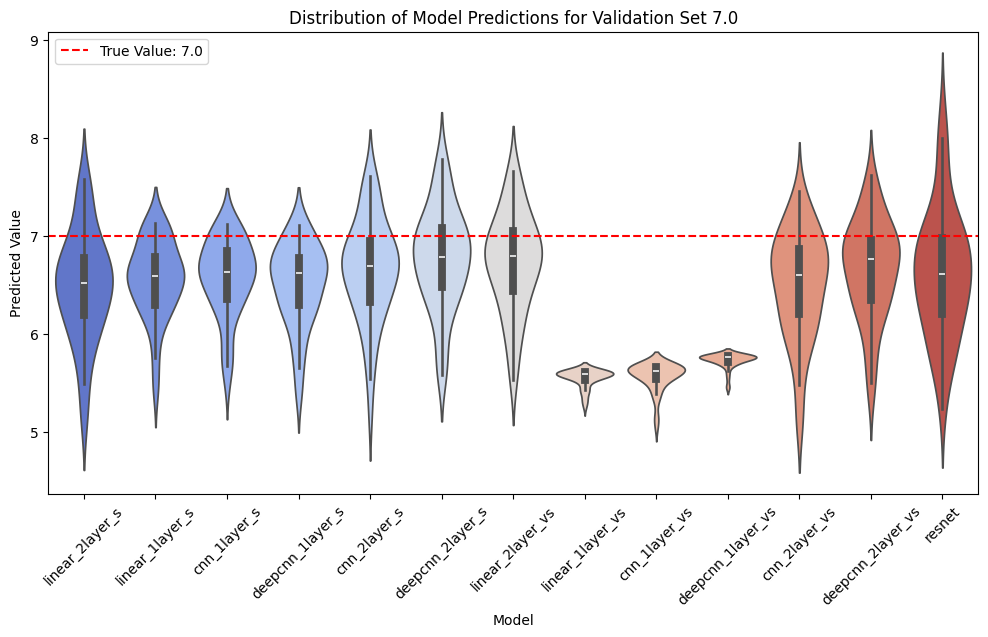

In [8]:
plot_model_predictions_violin(models, val_videos, val_labels, chosen_label=7.0)

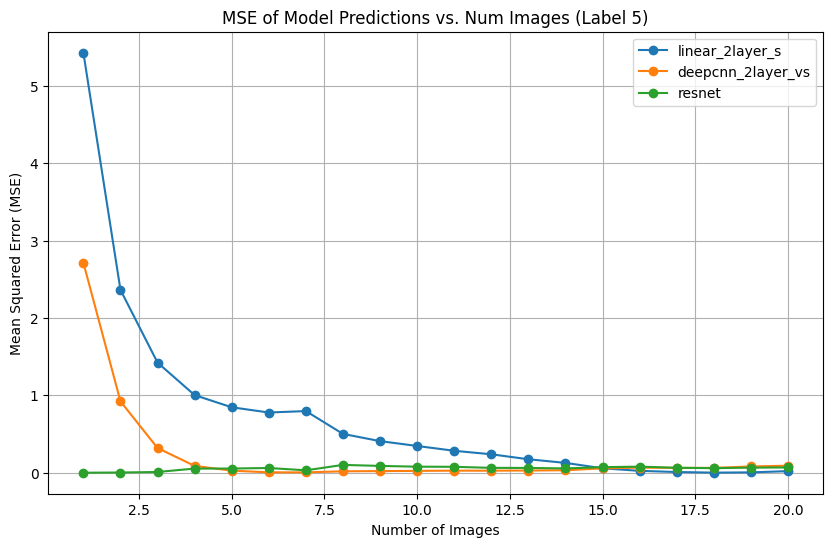

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_mse_vs_num_images(models, val_videos, val_labels, chosen_label):
    """
    Plots the Mean Squared Error (MSE) of model predictions as a function of num_images.
    
    Args:
    - models (dict): Dictionary of model names and instances.
    - val_videos (tuple): Tuple of validation video tensors.
    - val_labels (Tensor): Corresponding labels (torch.Tensor([1, 3, 5, 7])).
    - chosen_label (int): The validation label to visualize (must be 1, 3, 5, or 7).
    """
    
    # Select only the specified models
    selected_models = {name: model for name, model in models.items() if name in {"linear_2layer_s", "deepcnn_2layer_vs", "resnet"}}
    
    # Find index of the chosen label
    if chosen_label not in val_labels.tolist():
        print(f"Error: Chosen label {chosen_label} not in available labels {val_labels.tolist()}")
        return
    
    label_idx = val_labels.tolist().index(chosen_label)
    chosen_video = val_videos[label_idx]  # Get corresponding video
    
    num_images_range = range(1, chosen_video.shape[1] + 1)  # Range of num_images
    mse_results = {name: [] for name in selected_models}  # Store MSE results
    
    for num_images in num_images_range:
        input_video = chosen_video[:,:num_images]  # Select subset of images
        for name, model in selected_models.items():
            model.eval()
            with torch.no_grad():

                pred = model(input_video.contiguous()).mean().item()  # Aggregate predictions
                mse = (pred - chosen_label) ** 2  # Compute MSE
                mse_results[name].append(mse)
    
    # Plot MSE as a function of num_images
    plt.figure(figsize=(10, 6))
    for name, mse_values in mse_results.items():
        plt.plot(num_images_range, mse_values, label=name, marker='o')
    
    plt.xlabel("Number of Images")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(f"MSE of Model Predictions vs. Num Images (Label {chosen_label})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_mse_vs_num_images(models, val_videos, val_labels, 5)

In [11]:
for name, model in models.items() :
    if name != "resnet":
        model.eval()
        with torch.no_grad():
            embed_out = model.embedding(val_videos[3])
            embed_out = model.embedding(val_videos[0])
            print(embed_out.shape)
            print(f"{name}: Embedding var {torch.var(embed_out)}")


rnd = torch.rand_like(embed_out)
print(f"Rand: Embedding var {torch.var(rnd)}")


torch.Size([50, 20, 64])
linear_2layer_s: Embedding var 0.021459590643644333
torch.Size([50, 20, 64])
linear_1layer_s: Embedding var 0.020800428465008736
torch.Size([50, 20, 64])
cnn_1layer_s: Embedding var 0.01562945917248726
torch.Size([50, 20, 64])
deepcnn_1layer_s: Embedding var 0.16963325440883636
torch.Size([50, 20, 64])
cnn_2layer_s: Embedding var 0.025596704334020615
torch.Size([50, 20, 64])
deepcnn_2layer_s: Embedding var 0.2675718367099762
torch.Size([50, 20, 32])
linear_2layer_vs: Embedding var 0.012411866337060928
torch.Size([50, 20, 32])
linear_1layer_vs: Embedding var 0.01354720164090395
torch.Size([50, 20, 32])
cnn_1layer_vs: Embedding var 0.013713855296373367
torch.Size([50, 20, 32])
deepcnn_1layer_vs: Embedding var 0.23769241571426392
torch.Size([50, 20, 32])
cnn_2layer_vs: Embedding var 0.019573001191020012
torch.Size([50, 20, 32])
deepcnn_2layer_vs: Embedding var 0.16619053483009338
Rand: Embedding var 0.08394637703895569
